# Setup

In [1]:
%matplotlib notebook
import ipywidgets as widgets
from ipywidgets import interact
import numpy as np
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML,clear_output
from importlib import reload
from importData import importAll
import displayData
#from generateTrajectories import generateDiffuseTetherModel
import generateTrajectories
import bayesianTools
from extras import notebookSetupWidgets
import trajAnalysis
import plotly.express as px
import plotly.graph_objects as go
from scipy.signal import spectrogram
from scipy.special import factorial

# Import a dataframe

## Import experimental data

*Note*: The first import after will include reading from .csv and saving to a binary feather file and might take a few minutes.

#### Select experiments and/or particles with the widgets:

In [ ]:
full_df = importAll();df = full_df.copy();
expSelectWidget,rdmEnableWidget,rdmSameVideoWidget,keepStuckWidget,rdmSelectionWidget,specificEnableWidget,specificParticleSelectionWidget,buttonFilterWidget,filterDataframesFun=notebookSetupWidgets(widgets)
expSelectWidget.options = full_df.experiment.unique(); specificParticleSelectionWidget.min = full_df.particle.min(); specificParticleSelectionWidget.max = full_df.particle.max(); buttonFilterWidget.on_click(lambda b: filterDataframesFun(full_df,df))    
display(expSelectWidget,widgets.HBox((widgets.VBox((rdmEnableWidget,keepStuckWidget)),widgets.VBox((rdmSelectionWidget,rdmSameVideoWidget)))),widgets.HBox((specificEnableWidget,specificParticleSelectionWidget)),buttonFilterWidget)

### Alternatively, create a synthetic dataframe:

In [16]:
a = np.arange(10)
i = np.where(a>20)
a[i[0]]

array([], dtype=int32)

In [22]:
dt=1/30
N_steps = 2**10
#T_end=(2**12-1)*dt
N_particle=10
undersample_ratio=0#0.1
saveFiles=False
init_state=0#"random"
forceOneMode=0
T_stick= 50*dt*2*2
T_unstick= 50*dt*2*2
D= 0.3333
A= 0.05**2
isPar=True
# df = generateDiffuseTetherModel(T_stick=T_stick, T_unstick=T_unstick, D=D, A=A, dt=dt, N_steps=N_steps, N_particle=N_particle, init_state=init_state,undersample_ratio=undersample_ratio, saveFiles=saveFiles,forceOneMode=forceOneMode,isPar=isPar)
reload(generateTrajectories)
df = generateTrajectories.generateDiffuseTetherModel(T_stick=T_stick, T_unstick=T_unstick, D=D, A=A, dt=dt, N_steps=N_steps, N_particle=N_particle, init_state=init_state,undersample_ratio=undersample_ratio, saveFiles=saveFiles,forceOneMode=forceOneMode,isPar=isPar)
true_df = df.copy()

Beginning post-processing of the dataframe...
Padding the dataframe...
Interpolating the dataframe's padding...
Searching for colliding particles...
Labeling immobile particles...
Calculating radius of gyration...
Assigning crude estimates of diffusion coefficients...
Calculating local diffusion coefficients...
Calculating local diffusion coefficients...
Calculating local diffusion coefficients...
Done with post-processing!


<IPython.core.display.Javascript object>


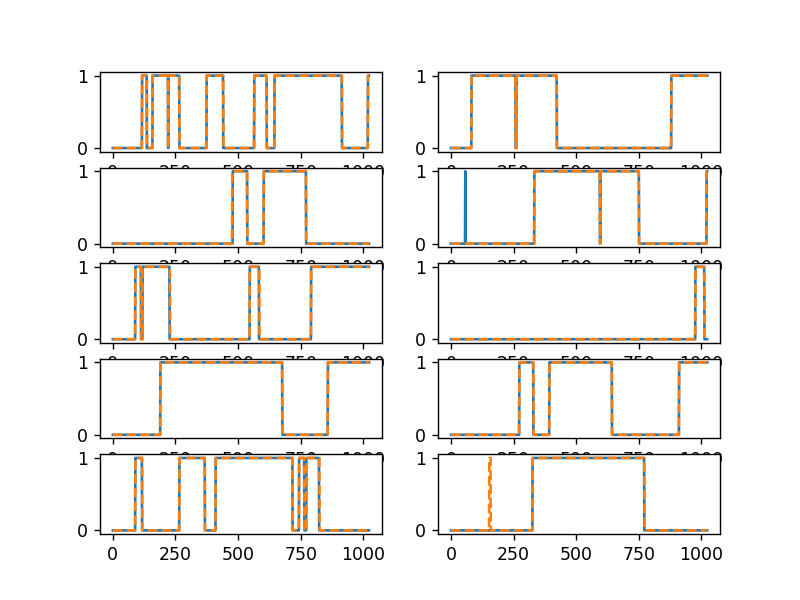

In [23]:
fig,ax=plt.subplots(5,2)

for n in range(5):    
    for m in range(2):
        cur_df = df.groupby("particle").get_group(5*m+n)
        reload(bayesianTools)
        X_arr = cur_df[["x","y"]].values

        params = [T_stick,T_unstick,D,2*A]
        S,XT=bayesianTools.tryViterbi(X_arr,
                                      params,dt)

        fullState= [[S[i],X_arr[i],XT[i]] for i in range(N_steps)]

        S_true = cur_df.state.values
        XT_true = cur_df[["x_tether","y_tether"]].values

        fullState_true= [[S_true[i],X_arr[i],XT_true[i]] for i in range(N_steps)]
        ax[n,m].plot(np.arange(N_steps),cur_df.state,'-')
        ax[n,m].plot(np.arange(N_steps),S,'--')

fig.savefig("stamstam.png")    

In [ ]:
np.where(S==1)

In [ ]:
_,ax=plt.subplots()
ax.plot(df.state,'-')
ax.plot(S,'--')


In [ ]:
reload(bayesianTools)
estL=np.sum([bayesianTools.stepLogLikelihood(fullState[i-1],fullState[i],dt,[T_stick,T_unstick,D,A]) for i in range(1,N_steps)])
truL=np.sum([bayesianTools.stepLogLikelihood(fullState_true[i-1],fullState_true[i],dt,[T_stick,T_unstick,D,A]) for i in range(1,N_steps)])
print(estL,truL)

In [ ]:
_,ax=plt.subplots()
xT_true = df.x_tether.values
xT_true[df.state==0.]=np.nan
ax.plot(xT_true,'-')
ax.plot(XT[:,0],'--')


In [ ]:
params = [T_stick,T_unstick,D,A]
X_arr = df[["x","y"]].values
N = len(X_arr)
K = N + 1
A = params[3]
forgetOldStuckThreshold = 30. * A
reload(bayesianTools)
def L(n, k, i):  # transition log likelihood from hidden state k at time n to hidden state i at time n+1
    # Filter out old stuck states: if next position is very far from some old stuck position, don't bother calculating
    if k > 0:
        if np.sum((X_arr[n + 1] - X_arr[k - 1]) ** 2) > forgetOldStuckThreshold:
            # print(np.sum((X_arr[n + 1] - X_arr[k - 1]) ** 2))
            return -np.inf

    # Parse n,k,i to cur_state and next_state:
    if k == 0:
        cur_state = [0, X_arr[n], [0, 0]]
    else:
        cur_state = [1, X_arr[n], X_arr[k - 1]]

    if i == 0:
        next_state = [0, X_arr[n + 1], [0, 0]]
    else:
        next_state = [1, X_arr[n + 1], X_arr[i - 1]]
    return bayesianTools.stepLogLikelihood(cur_state, next_state, dt, params)

In [ ]:
np.sum((X_arr[1]-X_arr[0])**2)/A

In [ ]:


reload(bayesianTools)
X_arr = df[["x","y"]].values

params = [T_stick,T_unstick,D,A]
S,XT=bayesianTools.tryViterbi(X_arr,
                              params,dt)

fullState= [[S[i],X_arr[i],XT[i]] for i in range(N_steps)]

S_true = df.state.values
XT_true = df[["x_tether","y_tether"]].values

fullState_true= [[S_true[i],X_arr[i],XT_true[i]] for i in range(N_steps)]

In [ ]:
L(0,0,0)

In [ ]:
_,

In [ ]:
L_mat[:,5]

In [ ]:
X_arr = df[:10][["x","y"]].values

In [ ]:
reload(bayesianTools)
n=4
bayesianTools.stepLogLikelihood([1,X_arr[n],[0,0]], [1,X_arr[n+1],[1,0]], dt, [T_stick,T_unstick,D,A])

In [ ]:
(dt/T_stick)/6.24609538e-04

In [ ]:
from extras import generate_CTMC_Matrix
print(generate_CTMC_Matrix(T_stick, T_unstick, dt))

In [ ]:
dt/T_stick

In [ ]:
df

In [ ]:
np.random.default_rng().random(size=[3,3])


In [ ]:
df.state.plot()

In [ ]:
nnn=1184
print("Var: "+str(df[nnn:2284].x.var()+df[nnn:2284].y.var()))
print("Std: "+str(np.sqrt(df[nnn:2284].x.var()+df[nnn:2284].y.var())))
print("Mean x: "+str(df[nnn:2284].x.mean())+", y: "+str(df[nnn:2284].y.mean()))

In [ ]:
df_orig = df.copy()

In [ ]:
reload(bayesianTools)
df = df_orig.copy()
#df = df[:3500]
#df.loc[len(df)-1,"state"]=0.5
orig_ind_switches = np.where(df.state==0.5)[0][1:-1]

d_array = np.arange(-10,11)
L = np.zeros(len(d_array))
params_arr = np.empty(len(d_array),dtype=object)

for i,d in enumerate(d_array):
    ind_switches = orig_ind_switches.copy()
    ind_switches[0]+=d
    L[i],params_arr[i]=bayesianTools.labeledParticleLikelihood(np.vstack(bayesianTools.extract_trajData_from_df(df)),ind_switches,0,returnParameters=True,
                                                              enforceModelParameters=[])#params)
    if d==0: #becasue maybe it wont be max
        Lmax = L[i]
        _,params=bayesianTools.labeledParticleLikelihood(np.vstack(bayesianTools.extract_trajData_from_df(df)),ind_switches,0,returnParameters=True)



dL = np.zeros(len(d_array))        
n = orig_ind_switches[0]
N = len(df)
[TT_stick, TT_unstick, DD, AA] = params
VX_arr= np.zeros(len(d_array))
predA_arr = np.zeros(len(d_array))
for i,d in enumerate(d_array):
    k_stick = np.ceil(len(orig_ind_switches)/2)
    k_unstick = np.floor(len(orig_ind_switches)/2)
    k = k_stick+k_unstick
    N_free = len(df[df.state==0.])+k
    N_stuck = len(df[df.state==1.])+k
    if d>0:
        DX = df.dr2.values[n : n+d+1].sum()/(4*DD*dt)
        VX = np.abs(d)*(df.x[n : n+d+1].var()+df.y[n : n+d+1].var())/AA
        dL[i] = -((N_free+d)*np.log((N_free+DX) / (N_free+d))
        +(N_stuck-d)*np.log((N_stuck-VX) /(N_stuck-d))
        +d* np.log(4*DD*dt/AA)+
        1*np.log(1+d*dt/TT_stick/1))      
        #dL[i] = -d* np.log(4*DD*dt/AA)
    elif d<0:
        DX = df.dr2.values[n+d : n+1].sum()/(4*DD*dt)
        VX = np.abs(d)*(df.x[n+d : n+1].var()+df.y[n+d : n+1].var())/AA
        dL[i] = -((N_free+d)*np.log((N_free-DX) / (N_free+d))
        +(N_stuck-d)*np.log((N_stuck+VX) /(N_stuck-d))
        +d* np.log(4*DD*dt/AA)+
        1*np.log(1+d*dt/TT_stick/1)) 
        #dL[i] = -(N_stuck-d)*np.log((N_stuck+VX) /(N_stuck-d))
    VX_arr[i]=VX*AA
    predA_arr[i]= (N_stuck*AA-np.sign(d)*VX_arr[i])/(N_stuck-d)
    #print(df[(n+d):].y.mean())
        
        
    
_,ax=plt.subplots()
ax.plot(d_array,L-Lmax,marker="*")
ax.plot(d_array,dL,marker="*")

In [ ]:
-((N_free+d)*np.log((N_free-DX) / (N_free+d))
        +(N_stuck-d)*np.log((N_stuck+VX) /(N_stuck-d))
        +d* np.log(4*DD*dt/AA)+
        1*np.log(1+d*dt/TT_stick/1))

In [ ]:
df.x[n-10 : n+ 11].values-df.x[n-10]

In [ ]:
n

In [ ]:
_,axes = plt.subplots()
axes.plot(df.frame,df.x)
axes.plot(df[df.state==1.].frame,df[df.state==1.].x)

In [ ]:
np.vstack(params_arr)

In [ ]:
df.state.plot()

In [ ]:
df.groupby("particle")

In [ ]:
dff = df.copy()

In [ ]:
sns.histplot(dff[dff.state==0.5].groupby("particle").apply(len)-2)
sns.lineplot(np.arange(13),100*bayesianTools.kEventsProb(np.arange(13),0,T_end,T_stick,T_unstick))

# Display Some Graphs

## Show trajectories

In [ ]:
startAtOrigin=False
if startAtOrigin:
    plotly_df=trajAnalysis.shiftTrajToOrigin(df)
else:
    plotly_df = df[df.particle==9].copy()
    plotly_df["S_est"]=S
plotly_df.y *=-1; plotly_df.particle = plotly_df.particle.astype(str) ; plotly_df.state = plotly_df.state.astype(int).astype(str)
# plotly_df["particle_state"] = plotly_df.particle+"_"+plotly_df.state
plotly_df["particle_state"] = plotly_df.particle+"_"+plotly_df.S_est.astype(str)
fig = px.line(plotly_df, x="x", y="y", color='particle_state',hover_data=['frame'],color_discrete_sequence=px.colors.qualitative.D3,)
#fig = px.line(plotly_df, x="x", y="y", color='particle_state',hover_data=['particle','state','isMobile','t','mass','n_neighbors','colliding_neighbors'],color_discrete_sequence=px.colors.qualitative.D3,)
fig.update_yaxes(scaleanchor = "x",scaleratio = 1,)
fig.show()

In [ ]:
plotly_df["particle_state"] = plotly_df.particle
fig = px.line(plotly_df, x="x", y="y", color='particle_state',hover_data=['frame'],color_discrete_sequence=px.colors.qualitative.D3,)
#fig = px.line(plotly_df, x="x", y="y", color='particle_state',hover_data=['particle','state','isMobile','t','mass','n_neighbors','colliding_neighbors'],color_discrete_sequence=px.colors.qualitative.D3,)
fig.update_yaxes(scaleanchor = "x",scaleratio = 1,)
fig.show()

## Trajectories Animation:

In [ ]:
reload(displayData)
max_frame = 51
startAtOrigin=True
doneTrajNoMarker=True
dispLegend=False
if "Traj_fig" in locals() : plt.close(Traj_fig)
Traj_fig, Traj_ax = plt.subplots(figsize=(5,5))
drawnLines=displayData.plotTrajectories(df,curParticlePivotSize=5., t_end=max_frame, doneTrajNoMarker=doneTrajNoMarker,startAtOrigin=startAtOrigin,dispLegend=False, ax=Traj_ax, useDrawnLines=False, drawnLines=[],hideLines=True,axForVelocityPlot=[],particlesForFixedColoring = [])
def animateTraj(t_end):
    displayData.notebookAnimateTraj(df,Traj_ax,t_end,max_frame,startAtOrigin=startAtOrigin,doneTrajNoMarker=doneTrajNoMarker,dispLegend=dispLegend,useDrawnLines=True,drawnLines=drawnLines,fps=0.,axForVelocityPlot=[],particlesForFixedColoring=[],curParticlePivotSize=5.)
ani = animation.FuncAnimation(Traj_fig, animateTraj, frames=max_frame); clear_output(wait=True); HTML(ani.to_jshtml())

## MSD Plot:

In [ ]:
default_groupby = "experiment"
if "MSD_fig" in locals() : plt.close(MSD_fig)
MSD_fig, MSD_ax = plt.subplots(figsize=(6, 4))
@interact(Log_Scale=True,group_by=["experiment","particle"],max_lagtime=(100,2000,10),N_sample_points = (2,101,1),equal_weight_per_particle=True)
#def update(group_by="experiment",Log_Scale=True,equal_weight_per_particle=True,step_lagtime=5,max_lagtime=100,):
def update(group_by=default_groupby,Log_Scale=False,equal_weight_per_particle=True,N_sample_points=21,max_lagtime=1000,):
    MSD_ax.cla()
    displayData.plot_MSD(df,isdfPadded=True, lagtime=np.unique(np.round(np.logspace(0,np.log10(max_lagtime),N_sample_points))), group_by=group_by, logscale=Log_Scale, ax=MSD_ax,eqParticleWeight=equal_weight_per_particle)
    MSD_ax.grid(True)

## Displacement Distribution $G(\Delta x,\Delta t)$:

In [ ]:
# set up plot
if "G_fig" in locals() : plt.close(G_fig)
G_fig, G_ax = plt.subplots(figsize=(6, 4))

dt_default = 3
xlim_default = 5.

@interact(dt=(1, min(200,df.frame.max()-1), 1),semiLogScale=True,direction=["xy", "x", "y"],group_by=["experiment","particle"],x_lim=(1., 30., 0.5),equal_weight_per_particle=True, clearAxes = True)
def update(dt=dt_default,x_lim=xlim_default,group_by="experiment",direction="xy",semiLogScale=True,equal_weight_per_particle=True,clearAxes = True):
    if clearAxes: G_ax.cla()        
    displayData.plot_G_dx_dt(G_df
                             ,isdfPadded=True, direction=direction, group_by=group_by, dt=dt, return_stats=False,semilogscale=semiLogScale,ax=G_ax,equal_particle_weight=equal_weight_per_particle)
    G_ax.set_xlim([-x_lim,x_lim])
    G_ax.set_ylim([1e-6,1e1]) if semiLogScale else G_ax.set_ylim([0,2.])   
    G_ax.grid(True)
    
#     sns.move_legend(G_ax,"lower left")
#     plt.setp(G_ax.get_legend().get_texts(), fontsize='7')  # for legend text
#     plt.setp(G_ax.get_legend().get_title(), fontsize='8')  # for legend title


# Bayesian

In [ ]:
dff = trajAnalysis.labelAllTrajectories(df,isPar=True)

In [ ]:
_,ax=plt.subplots()
ax.plot(df[df.particle==  4].state)
ax.plot(dff[dff.particle==4].state)

In [ ]:
D*dt

In [ ]:
_,ax=plt.subplots()
ax.plot(df.state)
#ax.plot(est_states,linestyle="--")


In [ ]:
df.bayesian_A

In [ ]:
X=np.arange(860,900)
labL=[bayesianTools.labeledParticleLikelihood(np.vstack(bayesianTools.extract_trajData_from_df(df)),
                                          [ 110,  536,  886,  919,  975]#[ 110,  536,  886,  919,  975]
                                           ,0) for n in X]
_,ax=plt.subplots()
ax.plot(X-886,labL,label="Stick Time")
plt.legend()

X=np.arange(890,930)
labL=[bayesianTools.labeledParticleLikelihood(np.vstack(bayesianTools.extract_trajData_from_df(df)),
                                          [ 110,  536,  886,  919,  975]#[ 110,  536,  886,  919,  975]
                                           ,0) for n in X]
ax.plot(X-919,labL,label="Unstick Time")
plt.legend()

In [ ]:
iterable_arr = np.asarray(list(itertools.product(np.asarray([-1, 0, 1]), repeat=4)))

In [ ]:
z=np.prod(np.diff(iterable_arr,axis=1)>-1,axis=1,dtype=bool)

In [ ]:
np.prod(iterable_arr>0,axis=1,dtype=bool)

In [ ]:
len(iterable_arr[z])

In [ ]:
_,ax=plt.subplots()
ax.plot(df.dr2.values)

In [ ]:
np.where(df.state==0.5)[0][1]

In [ ]:
reload(bayesianTools)
n=np.where(df.state==0.5)[0][1]

X=np.arange(n-50,n+200)
labL=np.asarray([bayesianTools.labeledParticleLikelihood(np.vstack(bayesianTools.extract_trajData_from_df(df)),
                                          y
                                           ,0) for y in X])
_,params = bayesianTools.labeledParticleLikelihood(np.vstack(bayesianTools.extract_trajData_from_df(df)),
                                          n
                                                   ,0,returnParameters=True)
_,ax=plt.subplots()
ax.plot(X-n,labL)

In [ ]:
(labL[np.where(X==n+d)]-labL[np.where(X==n)])[0]

In [ ]:
_,ax=plt.subplots()
ax.hist(np.random.randn(10**6),100)

In [ ]:
np.random.randint(-5,6)

In [ ]:
d=20
DX = np.sum(df.loc[n+1 : (n+d+1),"dr2"])
VX = np.sum((df.loc[n+1: (n+d+1),"x"]-df[df.state==1.].x.mean() )**2+(df.loc[n+1: (n+d+1),"y"]-df[df.state==1.].y.mean())**2)


pred_dL=-(
    (n+d)*np.log( (n+ np.sign(d)*DX/(4*D*dt))/(n+d))+
    (n-d)*np.log( (N-n-np.sign(d)*VX/A )/(N-n-d))+
    d*np.log(4*D*dt / A)+
    np.log(1+d/n)        
)
# pred_dL=-(
# (n+d)*np.log((n+DX/(4*D*dt) )/(n+d))+(n-d)*np.log((n-VX/A)/(n-d))+d*np.log(4*D*dt/A)
#     +np.log(1+d*dt/T_stick)
# )

# pred_dL = -d*np.log(4*D*dt/A)
true_dL = (labL[np.where(X==n+d)]-labL[np.where(X==n)])[0]

print("Pred: {} ; True: {}".format(np.round(pred_dL,2),np.round(true_dL,2)))



In [ ]:
d=10

In [ ]:
(np.sum(1-df.loc[n+1 : (n+d+1),"dr2"]/(4*D*dt))
 + np.sum(1+ ((df.loc[n+1: (n+d+1),"x"]-df[df.state==1.].x.mean() )**2+(df.loc[n+1: (n+d+1),"y"]-df[df.state==1.].y.mean())**2)/ A 
         )) + d* np.log(A/(4*D*dt))


In [ ]:
N = 1024
n = 447
-(
(df.loc[n+1,"dr2"]/(4*D*dt) + 1) * np.log(n*4*np.pi*D*dt) - ( ((df.loc[n+1,"x"]-df[df.state==1.].x.mean() )**2+(df.loc[n+1,"y"]-df[df.state==1.].y.mean())**2)/ A  +1)* np.log((N-n)*np.pi*A)
)

In [ ]:
np.nanmean(df[df.state==0.].dr2 / df[df.state==0.].dt/4)

In [ ]:
params[0]

In [ ]:
np.arange(10)[np.hstack([np.arange(5,6),np.arange(0,5),np.arange(6,10)])]

In [ ]:
1003.3783522758029-1005.7648073789106

In [ ]:
1003.3783522758029-1007.6013822982765

In [ ]:
T_unstick/dt

In [ ]:
df = df[df.particle==0]

In [ ]:
dt = 1/30.
T_stick = 100 * dt * 2 * 2
T_unstick = 40 * dt * 2 * 2


In [ ]:
np.where(df.state==0.5)[0][1:-1]


In [ ]:
[327 342 471 486 779 955]

In [ ]:

 bayesianTools.labeledParticleLikelihood(np.vstack(bayesianTools.extract_trajData_from_df(df)),
                                          [ 30, 137, 484, 603, 613, 741, 753, 987]
                                                   ,0,returnParameters=False)

In [ ]:
bb = []

In [ ]:
bb.append(3)

In [ ]:
bb

In [ ]:
[128 192 256 320 832 896 960]
[262 277 780 849 864 879]
[294 309 770 785 800 953]

In [ ]:
reload(bayesianTools)

est_states,_,_,_,_ = bayesianTools.labelExperimentTrajectories(df, T_stick,T_unstick)
# est_states,_,_,_,_ = bayesianTools.labelExperimentTrajectories(df, 34*0.2,34*0.2)
# est_states = bayesianTools.labelAllTrajectories(df).state

_,ax=plt.subplots()
# ax.plot(df_groundtruth.state)
ax.plot(df.state,linestyle="-")
ax.plot(est_states,linestyle="--")


In [ ]:
reload(bayesianTools)

est_states,_,_,_,_ = bayesianTools.labelExperimentTrajectories(df, T_stick,T_unstick)
# est_states,_,_,_,_ = bayesianTools.labelExperimentTrajectories(df, 34*0.2,34*0.2)
# est_states = bayesianTools.labelAllTrajectories(df).state

_,ax=plt.subplots()
# ax.plot(df_groundtruth.state)
ax.plot(df.state,linestyle="-")
ax.plot(est_states,linestyle="--")


In [ ]:
np.where(df_groundtruth.state==0.5)

In [ ]:
df.state.plot()

In [ ]:
reload(bayesianTools)

est_states,_,_,_,_ = bayesianTools.labelExperimentTrajectories(df, T_stick,T_unstick)

_,ax=plt.subplots()
ax.plot(df.state)
ax.plot(est_states,linestyle="--")


In [ ]:
np.where(est_states==0.5)

In [ ]:
np.where(df.state==0.5)

In [ ]:
[109 243 414 535 553 838]

In [ ]:
_,ax=plt.subplots()
ax.plot(df.x.values,df.y.values)

In [ ]:
#trajData = np.vstack(bayesianTools.extract_trajData_from_df(df)) #np.where(df[df.particle==0]["state"]==0.5)[0][1:-1]

In [ ]:
_,ax = plt.subplots()

ax.plot(df[df.particle==571].D_local_T_30)

In [ ]:
trajData = np.vstack(bayesianTools.extract_trajData_from_df(df)) #np.where(df[df.particle==0]["state"]==0.5)[0][1:-1]

In [ ]:
_,ax = plt.subplots()

ax.plot(df.frame,df.state)

In [ ]:
reload(bayesianTools)
bayesianTools.labelParticleTrajectory(trajData,T_stick,T_unstick,enforceModelParameters=[])

In [ ]:
bayesianTools.labeledParticleLikelihoodNew(np.vstack(trajData),[],0)

In [ ]:
reload(bayesianTools)
# out = bayesianTools.labelExperimentTrajectories(df[df.particle==534],200,300,isPar=True)
out = bayesianTools.labelParticleTrajectory(np.vstack(trajData),200,300)
print(out)

In [ ]:
_,ax = plt.subplots()
ax.plot(out[0])

In [ ]:
out[-1]

In [ ]:
a = np.array([0.0, 10.0, 20.0, 30.0])

b = np.array([1.0, 2.0, 3.0])

a[:, np.newaxis] + b

In [ ]:
np.zeros([4,1]).shape

In [ ]:
np.repmat([3],4)

In [ ]:
3113*trajData[0][1]

In [ ]:
np.max(trajData[0])

In [ ]:
trajData = np.vstack(bayesianTools.extract_trajData_from_df(df[df.particle==534])) #np.where(df[df.particle==0]["state"]==0.5)[0][1:-1]

In [ ]:
bayesianTools.labelParticleTrajectory(trajData,200,300,enforceModelParameters=[])

In [ ]:
reload(bayesianTools)
L = bayesianTools.labeledParticleLikelihoodNew(trajData,[389,430],0.,
                                                          enforceModelParameters=[
                                                              params_est[0],params_est[1],params_est[2],params_est[3]])
print(L)

In [ ]:
params_est

In [ ]:
bayesianTools.labelParticleTrajectory(trajData,T_stick,T_unstick,enforceModelParameters=params_est)

In [ ]:
reload(bayesianTools)
[st,M,STD]=bayesianTools.labelExperimentTrajectories(df,T_stick,T_unstick)
df["est_st"]=st
print(M)
_,ax=plt.subplots()
ax.plot(df.state)
ax.plot(df.est_st,'--')

In [ ]:
reload(bayesianTools)
LL,CC=bayesianTools.labelParticleTrajectory(trajData, params_est1[0], params_est1[1])#, enforceModelParameters=params_est1)

In [ ]:
np.where(df.state==0.5)

In [ ]:
np.mean((df.loc[df.state==0,["dx","dy"]]**2).sum(axis=1)/(4*dt))

In [ ]:
params_est1

In [ ]:
params_est1=params_est

In [ ]:
reload(bayesianTools)
L,params_est = bayesianTools.labeledParticleLikelihoodNew(trajData,np.where(df["state"]==0.5)[0][1:-1],0.,enforceModelParameters=params_est1,returnParameters=True)

In [ ]:
params_est==params_est1

In [ ]:
params_est

In [ ]:
trajData=bayesianTools.extract_trajData_from_df(df)

In [ ]:
df.frame[df.state==0].plot()

In [ ]:
np.sum(df.state==1)/2*dt

In [ ]:
df.state.plot(marker="*")

In [ ]:
L

In [ ]:
A

In [ ]:
np.where(df["state"]==0.5)[0][1:-1]

In [ ]:
LL = lambda x,y:x+y

In [ ]:
LL(1,2)

In [ ]:
b = [[1,2,3,4],[1,2,3,6],[1,3,np.nan,np.nan]]

In [ ]:
A=np.vstack(b)

In [ ]:
np.nanmean(A,axis=0)

In [ ]:
reload(bayesianTools)

bayesianTools.fine_graining_indices_range([1875,2216,3921],4096,341)

In [ ]:
def foo():
    return [1,2]

a = np.arange(3)
_,a[0]=foo()

In [ ]:
a

In [ ]:
1448 2473 3587 3969

In [ ]:
reload(bayesianTools)
trajData = bayesianTools.extract_trajData_from_df(df)
x,y=bayesianTools.labelParticleTrajectory(trajData, 100.,40.)
print(y)
# fig,ax=plt.subplots()
#ax.plot(y)

In [ ]:
_, ax = plt.subplots()
ax.plot(df.state)

In [ ]:
np.linspace(-5,5,dtype=int)

In [ ]:
a = np.linspace(0,5,60)

In [ ]:
b = a*1
b[0] = 8
print(a)

In [ ]:
A = np.zeros([3,2])

In [ ]:
for i in range(3):
    for j in range(2):
        A[i,j] = 3*i+(j+1)**2

In [ ]:
np.argmax(A)

In [ ]:
np.sqrt(4096)

In [ ]:
np.where(df["state"]==0.5)

In [ ]:
1856/64

In [ ]:
L,_=bayesianTools.labeledParticleLikelihoodNew(trajData, [1280,1856], 0)
print(L)

In [ ]:
reload(bayesianTools)

xx = np.arange(1100,1400)
yy=[bayesianTools.labeledParticleLikelihoodNew(trajData, [x,1900], 0) for x in xx]
fig,ax=plt.subplots()
ax.plot(xx,yy)
ax.set_ylabel('Log-likelihood')
ax.set_xlabel('Switch Time')

In [ ]:
yak=np.zeros(2,dtype=object)

In [ ]:
yak[0]=[1,2,3]
yak[1] = [6,7]
np.argmax(yak)

In [ ]:
np.arange(-3,6)

In [ ]:
yom=np.array(3)

In [ ]:
np.isscalar([])

In [ ]:
0*np.inf

In [ ]:
np.nansum([6,np.nan])

In [ ]:
reload(bayesianTools)

bayesianTools.labeledParticleLikelihoodNew(trajData, [], 0)

In [ ]:
x

In [ ]:
reload(bayesianTools)
bayesianTools.indLikelyEnoughPk(Pk)

In [ ]:
K_range = np.arange(0,10)
Pk = bayesianTools.kEventsProb(K_range, 0., df.tail(1).t.values, T_stick, T_unstick)
fig,ax=plt.subplots()
ax.plot(K_range,Pk)

In [ ]:
mmm=np.asarray(x[100799])

In [ ]:
mmm

In [ ]:
reload(bayesianTools)

print(bayesianTools.labeledParticleLikelihoodNew(trajData, mmm, 0))
print(bayesianTools.labeledParticleLikelihoodNew(trajData, [1970, 2037, 2557, 2593], 0))


In [ ]:
s = df.state.values
deltaT = 1./df.fps.values[0]
s[0] = s[1]
s[-1] = s[-2]
ds = np.diff(s)
x = df.x.values
dx = df.dx.values
y = df.y.values
dy = df.dy.values
t = df.t.values
dt = df.dt.values
T = np.nansum(dt)
N_tot = T/deltaT

k_field = np.sum(np.abs(ds))
k_stick = np.sum(np.abs(ds)*(ds>0))
k_unstick = np.sum(np.abs(ds)*(ds<0))
n_free = 1+k_stick
n_stuck = k_unstick
N_free = np.sum(1-s)
N_stuck = np.sum(s)

D_est = np.nansum((1-s)*(dx**2+dy**2)/(4*dt))/N_free

ind_start_stuck = np.where((s[1:]==1) & (s[:-1]==0.5))[0]+1
ind_end_stuck = np.where((s[1:]==0) & (s[:-1]==0.5))[0]+1
if len(ind_end_stuck)<len(ind_start_stuck):
    ind_end_stuck = np.append(ind_end_stuck,(len(s)))

A_est = 0
for i in range(len(ind_start_stuck)):
    x_seg = x[ind_start_stuck[i]:ind_end_stuck[i]]
    y_seg = y[ind_start_stuck[i]:ind_end_stuck[i]]
    A_est += np.sum ((x_seg-np.mean(x_seg))**2) / N_stuck
    A_est += np.sum ((y_seg-np.mean(y_seg))**2) / N_stuck    

tau1_est = np.nansum((1-s)*dt)/n_free
tau2_est = np.nansum(s*dt)/n_stuck

L_spatial = -(N_tot + n_free*tau1_est/deltaT * np.log(4*np.pi*deltaT*D_est) + n_stuck*tau2_est/deltaT * np.log(np.pi*A))              
L_temporal = -k_field-1 - n_free*np.log(tau1_est) -n_stuck*np.log(tau2_est)
L_Pk =  np.log(bayesianTools.kEventsProb(k_field,0.,T,tau1_est,tau2_est))

L_est = L_spatial+L_temporal+L_Pk
print(L_spatial)
print(L_temporal)
print(L_Pk)
print(L_est)

In [ ]:
tau2_est

In [ ]:
n_stuck

In [ ]:
fig,ax=plt.subplots()
plt.plot(s)

In [ ]:
df.state[1]

In [ ]:
df.state = np.ceil(orig_state)

In [ ]:
#orig_state=df.state

In [ ]:
df.particle.unique()

In [ ]:
T = 0.5
T_stick = 1.8409255338946
T_unstick = 1.485168343137783
np.abs(T_stick - T_unstick) / T + T / np.abs(T_stick - T_unstick)
np.abs(T_stick-T_unstick)/(T_unstick+T_stick)

In [ ]:
reload(bayesianTools)
T = 400
tau1 = 8
tau2 = 6
r_mean = (1/tau1 + 1/tau2) /2
#P=([bayesianTools.kEventsProb(k, 0,T,tau1,tau2) for k in np.arange(0,200)])
P=bayesianTools.kEventsProb(np.arange(0,200), 0.,T,tau1,tau2)
fig,ax=plt.subplots()
ax.set_title(rf'$T={T}, \tau_1={tau1}, \tau_2={tau2}$')
ax.plot(P,label=rf'$P_k$')

# lamb =r_mean*T
lamb = T/((tau1+tau1)/2)
# lamb = T/np.min([tau1,tau2])
# Pois = [np.exp(-lamb)*lamb**x/factorial(x) for x in np.arange(0,200)]
# ax.plot(Pois,label=r'$Pois(\frac{2T}{\tau_1+\tau_2})$')
# ax.plot(Pois,label=r'$Pois(\frac{T}{\tau_1})$')

T = 400
tau1 = 6
tau2 = 8
r_mean = (1/tau1 + 1/tau2) /2
#P=([bayesianTools.kEventsProb(k, 0,T,tau1,tau2) for k in np.arange(0,200)])
P=bayesianTools.kEventsProb(np.arange(0,200), 1.,T,tau1,tau2)
ax.set_title(rf'$T={T}, \tau_1={tau1}, \tau_2={tau2}$')
ax.plot(P,label=rf'$P_k$')


ax.legend()

In [ ]:
P=bayesianTools.kEventsProb(np.arange(0,200), 0,5.,2.,3.)


In [ ]:
tau2

In [ ]:
reload(bayesianTools)
from bayesianTools import kEventsProbTEMP

In [ ]:
sum(P)

In [ ]:
reload(bayesianTools)
P=[bayesianTools.kEventsProbNew(K,0,10,3,5) for K in range(30)]
sum(P)

In [ ]:
reload(bayesianTools)
K=1
bayesianTools.kEventsProbNew(K,0,10,30,5)

In [ ]:
plt.plot(b)
plt.show()

In [ ]:
df[df.state==0].dr2.mean()/dt/4

In [ ]:
np.min(np.where(np.arange(10)>5))

In [ ]:
np.mean(np.diff(df.t.values[df.state==0.5])[1::2])/T_unstick

In [ ]:
print(stick_times)
print(T_unstick)

In [ ]:
reload(bayesianTools)
T_stick_arr = [3.]
T_unstick_arr =[7.]
D_arr =[5.,6.]
A_arr =[9.,50.]
bayesianTools.gridLikelihood(df, T_stick_arr, T_unstick_arr, D_arr, A_arr, usePar=False)
args_iterable = itertools.product(T_stick_arr, T_unstick_arr, D_arr, A_arr)
args_list = list(args_iterable)

In [ ]:
D_mat = np.reshape(args_list[:,2],[2,2])
A_mat = np.reshape(args_list[:,2],[2,2])

In [ ]:
np.asarray(args_list)

In [ ]:
np.where([False])

In [ ]:
np.max(L)-L

In [ ]:
plt.figure(fig1)

In [ ]:
f_arr = [fig1,fig2,fig]

In [ ]:
sns.lineplot(X_arr/X[i] , L-np.max(L) , linewidth=2.5,label=X_str[i])
plt.show()

In [ ]:
Z_arr = np.logspace(-1,1,41)*Z
W_arr = np.logspace(-1,1,41)*W
L=bayesianTools.gridLikelihood(df,[T_stick],[T_unstick], Z_arr, W_arr, usePar=True,saveFiles=True)
L_mat2= np.reshape(L,[len(Z_arr),len(W_arr)])


In [ ]:
reload(bayesianTools)

X = [T_stick,T_unstick,D,A]
X_str = ["T_stick","T_unstick","D","A"]

fig,ax = plt.subplots()
fig1,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()
ax_arr = [ax1,ax2, ax]
f_arr = [fig1,fig2,fig]
for i in range(4):
    array_arr = [[T_stick],[T_unstick],[D],[A]]
    X_arr = np.logspace(-1,1,201)*X[i]
    array_arr[i]=X_arr    
    L=bayesianTools.gridLikelihood(df,array_arr[0],array_arr[1],array_arr[2],array_arr[3], usePar=True,saveFiles=True)
    sns.lineplot(X_arr/X[i] , L-np.max(L) , linewidth=2.5,label=X_str[i],ax=ax)
    sns.lineplot(X_arr/X[i] , L-np.max(L) , linewidth=2.5,label=X_str[i],ax=ax_arr[int(np.floor(i/2))])

for a in ax_arr:
    a.set_xscale("log")
    #a.set_yscale("log")
    a.set_ylabel('Log-Likelihood - max')
    a.set_xlabel('Param/True')
    a.legend()
    
for j,f in enumerate(f_arr):
    plt.figure(f)
    plt.savefig("myfig_L_"+str(j)+".png",dpi=400)
    
X = T_stick
Y = T_unstick
Z = D
W = A
X_arr = np.logspace(-1,1,101)*X
Y_arr = np.logspace(-1,1,101)*Y
Z_arr = np.logspace(-1,1,101)*Z
W_arr = np.logspace(-1,1,101)*W
L=bayesianTools.gridLikelihood(df, X_arr, Y_arr, [D], [A], usePar=True,saveFiles=True)
L_mat1= np.reshape(L,[len(X_arr),len(Y_arr)])
L=bayesianTools.gridLikelihood(df,[T_stick],[T_unstick], Z_arr, W_arr, usePar=True,saveFiles=True)
L_mat2= np.reshape(L,[len(Z_arr),len(W_arr)])




In [ ]:
np.floor(i/2)

In [ ]:
reload(bayesianTools)

X = T_stick
Y = T_unstick
X_arr = np.logspace(-1,1,101)*X
Y_arr = np.logspace(-1,1,101)*Y
L=bayesianTools.gridLikelihood(df, X_arr, Y_arr, [D], [A], usePar=True,saveFiles=True)
L_mat= np.reshape(L,[len(X_arr),len(Y_arr)])
fig = px.imshow(np.exp(L_mat-np.max(L_mat[:])),labels=dict(x="T<sub>stick</sub>/True", y="T<sub>unstick</sub>/True"),
                x=X_arr/X,y=Y_arr/Y)
fig.layout.coloraxis.colorbar.title = 'Likelihood / max'
fig.update_xaxes(type="log")
fig.update_yaxes(type="log")
fig.update_xaxes(side="top")
fig.show()

In [ ]:
L_mat1.shape

In [ ]:
reload(bayesianTools)
#stick unstick D a
#init_state=1
X = T_stick
Y = T_unstick
X_arr = np.logspace(-1,1,101)*X
Y_arr = np.logspace(-1,1,101)*Y
# X_arr = np.linspace(0.5,2,31)*X
# Y_arr = np.linspace(0.5,2,31)*Y
# L_mat = np.zeros([len(X_arr),len(Y_arr)])

# gb = df.groupby("particle")
# for _,particle_df in gb:
#     getL = lambda x: bayesianTools.labeledParticleLikelihood(particle_df, x[0], x[1],x[2],x[3])
#     for i in range(len(X_arr)):
#         for j in range(len(Y_arr)):
#             L_mat[i,j] +=getL([X_arr[i],Y_arr[j],D,A])/len(particle_df)
    
fig = px.imshow(np.exp(L_mat1-np.max(L_mat1[:])),labels=dict(x="T<sub>stick</sub>/True", y="T<sub>unstick</sub>/True"),
                x=X_arr/X,y=Y_arr/Y)
    # fig = px.imshow(np.exp(L_mat-np.max(L_mat[:])),labels=dict(x="D/D<sub>True</sub>", y="A/A<sub>True</sub>"),
#                 x=X_arr/X,y=Y_arr/Y)
fig.layout.coloraxis.colorbar.title = 'Likelihood / max'
fig.update_xaxes(type="log")
fig.update_yaxes(type="log")
fig.update_xaxes(side="top")
fig.show()


In [ ]:
reload(bayesianTools)
#stick unstick D a
#init_state=1
X = D
Y = A
X_arr = np.logspace(-.7,.7,31)*X
Y_arr = np.logspace(-.7,.7,31)*Y
# X_arr = np.linspace(0.5,2,31)*X
# Y_arr = np.linspace(0.5,2,31)*Y
L_mat = np.zeros([len(X_arr),len(Y_arr)])

gb = df.groupby("particle")
for _,particle_df in gb:
    getL = lambda x: bayesianTools.labeledParticleLikelihood(particle_df, x[0], x[1],x[2],x[3])
    for i in range(len(X_arr)):
        for j in range(len(Y_arr)):
            L_mat[i,j] +=getL([T_stick,T_unstick,X_arr[i],Y_arr[j]])/len(particle_df)
    
fig = px.imshow(np.exp(L_mat-np.max(L_mat[:])),labels=dict(x="D/D<sub>True</sub>", y="A/A<sub>True</sub>"),
            x=X_arr/X,y=Y_arr/Y)
fig.layout.coloraxis.colorbar.title = 'Likelihood / max'
fig.update_xaxes(type="log")
fig.update_yaxes(type="log")
fig.update_xaxes(side="top")
fig.show()


In [ ]:
reload(bayesianTools)
bayesianTools.labeledParticleLikelihood(df[df.particle==10],T_stick,T_unstick,D,A)

In [ ]:
fig = go.Figure(data=go.Heatmap(
                   z=np.exp(L_mat-np.max(L_mat[:])),
                   x=X_arr/X,
                   y=Y_arr/Y,
                   hoverongaps = False))
fig.layout.coloraxis.colorbar.title = 'Likelihood / max'
fig.update_xaxes(type="log")
fig.update_yaxes(type="log")
fig.show()

In [ ]:
reload(bayesianTools)
#stick unstick D a
#init_state=1
X = A
X_arr = np.logspace(-.3,.3,150)*X
L_arr = np.zeros(X_arr.shape)

gb = df.groupby("particle")
for _,particle_df in gb:
    getL = lambda x: bayesianTools.labeledParticleLikelihood(particle_df, x[0], x[1],x[2],x[3])
    L_arr += [getL([T_stick,T_unstick,D,x_iter]) for x_iter in X_arr]


f, ax = plt.subplots();
sns.lineplot(x=X_arr/X,y=L_arr,marker="*")
ax.set_xscale("log"); ax.set_ylim([np.min(L_arr),np.max(L_arr)]);




In [ ]:
df.experiment.unique()[0].lower

In [ ]:
df.t

In [ ]:
fig = px.line(df, x="t", y="D_local_T_30", color='state',hover_data=['particle','state','isMobile','t','mass'],color_discrete_sequence=px.colors.qualitative.D3,)
fig.show()

In [ ]:
df.y.var()+df.x.var()

In [ ]:
startAtOrigin=True
plotly_df = df.copy()[df.particle==0] # df_result
plotly_df.y *=-1; plotly_df.particle = plotly_df.particle.astype(str) ; plotly_df.state = plotly_df.state.astype(int).astype(str)
fig = px.line(plotly_df, x="x", y="y", color='state',hover_data=['particle','state','isMobile','t','mass'],color_discrete_sequence=px.colors.qualitative.D3,); fig.update_yaxes(scaleanchor = "x",scaleratio = 1,)
fig.show()

In [ ]:
T_stick= 1000*dt
T_unstick= 200*dt
D= 0.3333
A= 0.1**2

In [ ]:
df

In [ ]:
df = df[::2].reset_index()

In [ ]:
reload(bayesianTools)
plt.close("all")
# T_stick *= 1+ 0.9*(np.random.rand()-0.5)
# T_unstick *= 1+ 0.9*(np.random.rand()-0.5)
# D *= 1+ 0.01(np.random.rand()-0.5)
# A *= 1+ 0.7*(np.random.rand()-0.5)
# T_stick = 2.
# T_unstick = 3.
# D = 0.1
# A = 0.001



df_out,maxL = bayesianTools.particleLikelihood(df, T_stick, T_unstick, D, A, 1)

w
figg, axx = plt.subplots(figsize=(5,5))
figv, axv = plt.subplots(figsize=(5,5))
startAtOrigin=False
z=displayData.plotTrajectories(df_out, t_end=len(df_out), doneTrajNoMarker=doneTrajNoMarker,startAtOrigin=startAtOrigin,dispLegend=False, ax=axx, useDrawnLines=False, drawnLines=[],hideLines=False,axForVelocityPlot=axv)

# trajData = bayesianTools.extract_trajData_from_df(df)


# df.loc[df.index[-1],"state"]=0.5
# ind = df["state"] == 0.5
# ind[0] = True
# t_stick_unstick_with_boundary = df.t[ind]
# t_stick_unstick = t_stick_unstick_with_boundary[1:-1]

# dt_for_jac = 0.02 * np.ones(len(t_stick_unstick))
# log_P_k = np.log(bayesianTools.kEventsProb(len(t_stick_unstick), 0, df.t.values.max(), T_stick=T_stick,
#                                            T_unstick=T_unstick).astype(
#     float) * np.abs(1))  # involve init state prior
# true_likelihood = log_P_k + bayesianTools.specificTrajectoryLikelihood(trajData, 0, t_stick_unstick,
#                                                                        dt_for_jac, T_stick=T_stick,
#                                                                        T_unstick=T_unstick,
#                                                                        D=D, A=A)

# plt.figure()
# plt.subplot(1, 3, 1)
# ax = plt.gca()
# displayData.plotTrajectories(df, t_end=2000, startAtOrigin=True, doneTrajNoMarker=True, ax=ax)
# ax.set_title("True ; L=" + "{:.2f}".format(true_likelihood))
# df_unsplit, max_likelihood = bayesianTools.particleLikelihood(df.head(80), T_stick=T_stick, T_unstick=T_unstick, D=D,
#                                                                    A=A, mode=1)


# N = len(df)
# half_N = int(N / 2)
# df1, max_likelihood1 = bayesianTools.particleLikelihood(df.head(half_N), T_stick=T_stick, T_unstick=T_unstick,
#                                                               D=D, A=A,
#                                                               mode=1)
# df2, max_likelihood2 = bayesianTools.particleLikelihood(df.tail(half_N), T_stick=T_stick, T_unstick=T_unstick,
#                                                               D=D, A=A,
#                                                               mode=1)
# df_split = df1.append(df2)


# plt.subplot(1, 3, 2)
# ax = plt.gca()
# displayData.plotTrajectories(df_unsplit, t_end=2000, startAtOrigin=True, doneTrajNoMarker=True, ax=ax)
# ax.set_title("Unsplit ; L=" + "{:.2f}".format(max_likelihood))
# plt.subplot(1, 3, 2)
# ax = plt.gca()

# plt.subplot(1, 3, 3)
# ax = plt.gca()
# displayData.plotTrajectories(df_split, t_end=2000, startAtOrigin=True, doneTrajNoMarker=True, ax=ax)
# ax.set_title("Split ; L=" + "{:.2f}".format(max_likelihood1 + max_likelihood2))
# plt.show(block=False)

# plt.figure()
# plt.plot(df.frame,df.state,marker='*')
# plt.plot(df_unsplit.frame,df_unsplit.state, linestyle="--",marker='*')
# plt.plot(df_split.frame,df_split.state, linestyle=":",marker='*')



In [ ]:
df_groundtruth=df.copy()

In [ ]:
df_assigned.columns

In [ ]:
df_assigned = df.copy()

In [ ]:
df = df_assigned.copy()

In [ ]:
df["true_state"] = df_groundtruth["state"]

In [ ]:
len(df[df["true_state"]==1.])

In [ ]:
len(df[(df["true_state"]!=df["state"]) & (df["true_state"]==1.)  ] )/len(df)

In [ ]:
0.28356680381720956/0.3

In [ ]:
ZZ=df.groupby("particle").first().bayesian_T_unstick
print(ZZ[~ZZ.isna()].mean())
print(ZZ[~ZZ.isna()].std()/ZZ[~ZZ.isna()].mean())

In [ ]:
for particle in range(1000):
    print("Particle {} has {} switches".format(particle,
                                              -2+np.sum(df[df.particle==particle].state==0.5)))

In [ ]:
reload(bayesianTools)
df["true_state"]=true_df["state"]
df=bayesianTools.labelAllTrajectories(df,isPar=True)

In [ ]:
relabeled_df = df.copy()

In [ ]:
print("D = {} +- {}".format(np.round(df.bayesian_D.mean(),2) , np.round(df.bayesian_D.std(),2)))
print("A = {} +- {}".format(np.round(df.bayesian_A.mean(),5) , np.round(df.bayesian_A.std(),5)))
print("Ts = {} +- {}".format(np.round(df.bayesian_T_stick.mean(),2) , np.round(df.bayesian_T_stick.std(),2)))
print("Tu = {} +- {}".format(np.round(df.bayesian_T_unstick.mean(),2) , np.round(df.bayesian_T_unstick.std(),2)))

In [ ]:
print("D = {} +- {}".format(np.round(relabeled_df.bayesian_D.mean(),2) , np.round(relabeled_df.bayesian_D.std(),2)))
print("A = {} +- {}".format(np.round(relabeled_df.bayesian_A.mean(),5) , np.round(relabeled_df.bayesian_A.std(),5)))
print("Ts = {} +- {}".format(np.round(relabeled_df.bayesian_T_stick.mean(),2) , np.round(relabeled_df.bayesian_T_stick.std(),2)))
print("Tu = {} +- {}".format(np.round(relabeled_df.bayesian_T_unstick.mean(),2) , np.round(relabeled_df.bayesian_T_unstick.std(),2)))

In [ ]:
T_unstick/T_end

In [ ]:
_,ax=plt.subplots(10,2)
for i in range(10):
    for j in range(2):
        smalldf = df[df.particle==i+j*10]
        ax[i,j].plot(smalldf.true_state)
        ax[i,j].plot(smalldf.state,linestyle="--")
        ax[i,j].plot(relabeled_df[relabeled_df.particle==i+j*10].state,linestyle=":")